In [2]:
import os

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision # for vgg16/19
from PIL import Image

from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_csv('prep_data/epochs/0/0_dog 7_4_6.csv')
data

,Unnamed: 0,TIME(2022/07/06 12:39:07.507),FPOGX,FPOGY,FPOGID,FPOGV,LPMM,LPMMV,RPMM,RPMMV,GSR,GSRV,HR,HRV,Image,Arousal,Valence
0,7573,122.76831,0.45358,0.50776,224,1,1.67199,0,3.89673,1,262256,1,85,1,Images/dog 7.jpg,4,6
1,7574,122.78442,0.45338,0.50856,224,1,1.67199,0,3.61032,1,261980,1,85,1,Images/dog 7.jpg,4,6
2,7575,122.80078,0.45327,0.50885,224,1,1.67199,0,3.69905,1,258110,1,85,1,Images/dog 7.jpg,4,6
3,7576,122.81714,0.45316,0.50887,224,1,1.67199,0,3.61293,1,262033,1,85,1,Images/dog 7.jpg,4,6
4,7577,122.83325,0.45273,0.50853,224,1,1.67199,0,2.91322,1,259693,1,85,1,Images/dog 7.jpg,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,7869,127.60474,0.09939,0.56685,232,0,2.21087,0,3.09987,1,239326,1,83,1,Images/dog 7.jpg,4,6
297,7870,127.62061,0.08465,0.54435,232,0,2.21087,0,3.29431,1,241096,1,83,1,Images/dog 7.jpg,4,6
298,7871,127.63672,0.07976,0.55757,232,0,2.21087,0,3.15171,1,242866,1,83,1,Images/dog 7.jpg,4,6
299,7872,127.65308,0.08623,0.56243,233,1,2.21087,0,3.13252,1,239063,1,83,1,Images/dog 7.jpg,4,6


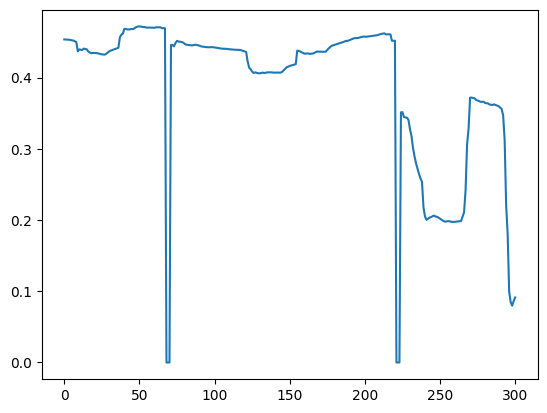

In [4]:
plt.plot(data.FPOGX)
# plt.plot(data.FPOGX.rolling(window=10, min_periods=0, center=True).mean())

In [5]:
data.LPMM.mean(),  data.LPMM.std()

(2.2965422591362126, 0.38497949389226677)

In [6]:
data.loc[data['FPOGV'] == 0, ['FPOGX', 'FPOGY']] = np.nan
data.loc[data['LPMMV'] == 0, ['LPMM']] = np.nan
data.loc[data['RPMMV'] == 0, ['RPMM']] = np.nan
data.loc[data['GSRV'] == 0, ['GSR']] = np.nan
data.loc[data['HRV'] == 0, ['HR']] = np.nan

data[['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']] = data[['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']].interpolate(method='linear', axis=0)

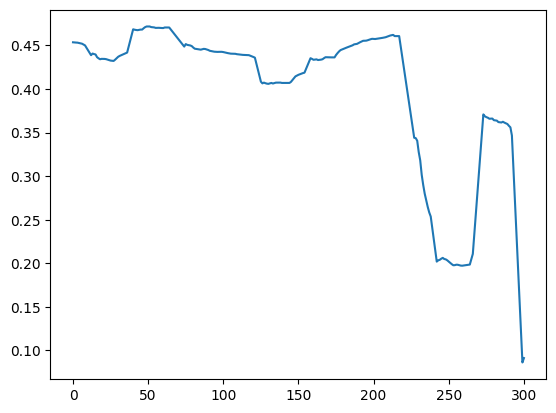

In [7]:
plt.plot(data.FPOGX)
# plt.plot(data.GSR.rolling(window=60, min_periods=0, center=True).mean())

In [8]:
im_size = 180
i1, i2 = 0, 300

img_ = np.zeros((im_size, im_size), dtype=np.uint8)
x0, y0 = data.FPOGX[i1], data.FPOGY[i1]
for i in range(i1, i2):
    if (data.FPOGID[i] != data.FPOGID[i+1]):

        x1, y1 = int(x0*im_size), int(y0*im_size)  
        x2, y2 = int(data.FPOGX[i]*im_size), int(data.FPOGY[i]*im_size)   

        cv2.line(img_, (x1, y1), (x2, y2), 255, 1)

        overlay = img_.copy()
        radius = int(((y2-y1)**2 + (x2-x1)**2)**0.5 / 5)
        cv2.circle(overlay, (x2, y2), radius, 255, -1)
        alpha = 0.5
        img_ = cv2.addWeighted(overlay, alpha, img_, 1 - alpha, 0)

        x0, y0 = data.FPOGX[i], data.FPOGY[i]


x1, y1 = int(x0*im_size), int(y0*im_size)   
x2, y2 = int(data.FPOGX[i2-1]*im_size), int(data.FPOGY[i2-1]*im_size)  

cv2.line(img_, (x1, y1), (x2, y2), 255, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

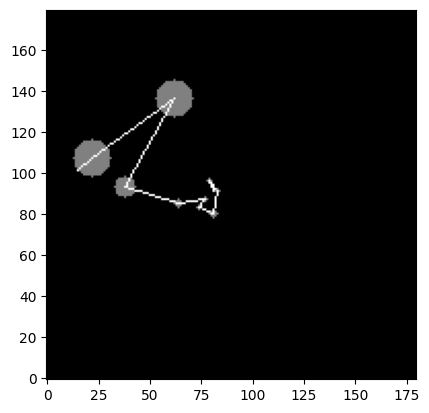

In [9]:
plt.imshow(img_, origin='lower', cmap='gray')

(0.0, 1.0)

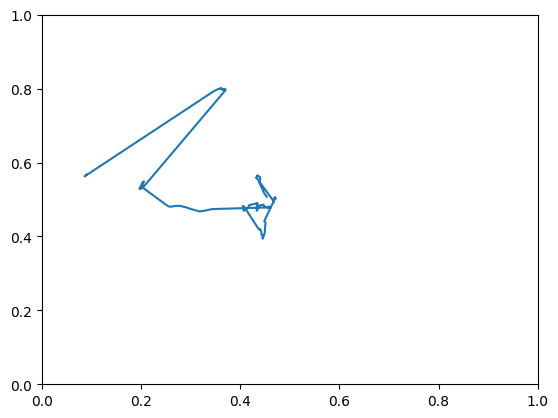

In [10]:
plt.plot(data.FPOGX, data.FPOGY)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [11]:
# df path, participant, image, arousal, valence 

df = {
    'path':[], 'participant':[], 'image_seq':[], 'image':[], 'arousal':[], 'valence':[] 
}
imgs = os.listdir('raw_data/Images')
imgs_lower = [i.lower() for i in imgs]

for part in os.listdir('prep_data/epochs/'):
    for path in os.listdir('prep_data/epochs/'+part):
    
        if path.split('_')[1].lower()+'.jpg' not in imgs: # there are some troubles with imgs_lower letter cases for some images
            idx = imgs_lower.index(path.split('_')[1]+'.jpg')
            df['image'] = df['image'] + [imgs[idx]]
        else:
            df['image'] = df['image'] + [path.split('_')[1]+'.jpg']
    
        df['path'] = df['path'] + [path]
        df['participant'] = df['participant'] + [int(part)]
        df['image_seq'] = df['image_seq'] + [int(path.split('_')[0])]
        
            
        df['arousal'] = df['arousal'] + [int(path.split('_')[-2])]
        df['valence'] = df['valence'] + [int(path.split('_')[-1][:-4])]
        
df = pd.DataFrame(df)
df = df.sort_values(by=['participant', 'image_seq'])

In [12]:
df

,path,participant,image_seq,image,arousal,valence
0,0_dog 7_4_6.csv,0,0,dog 7.jpg,4,6
111,1_falcon 1_4_5.csv,0,1,falcon 1.jpg,4,5
122,2_koi fish 1_5_1.csv,0,2,koi fish 1.jpg,5,1
133,3_kazan 4_4_4.csv,0,3,kazan 4.jpg,4,4
144,4_embroidery 1_4_4.csv,0,4,embroidery 1.jpg,4,4
...,...,...,...,...,...,...
11684,165_weights 1_1_4.csv,159,165,weights 1.jpg,1,4
11685,166_tsarskoe selo 2_1_7.csv,159,166,tsarskoe selo 2.jpg,1,7
11686,167_wasp 2_1_4.csv,159,167,wasp 2.jpg,1,4
11687,168_sewing 1_1_5.csv,159,168,sewing 1.jpg,1,5


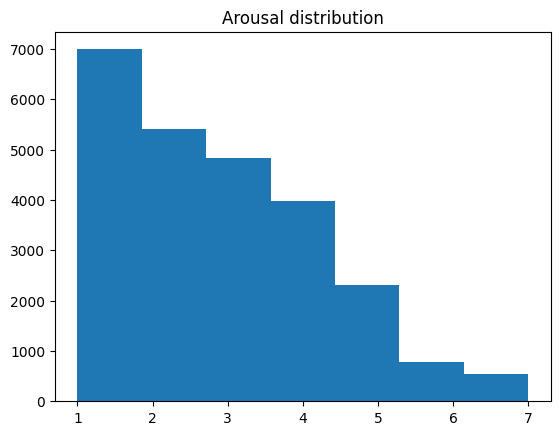

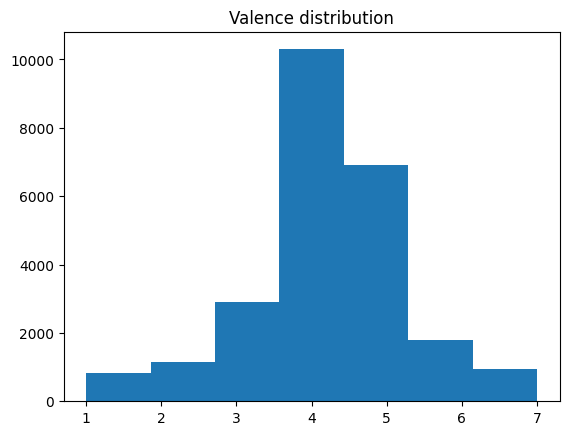

In [13]:
plt.hist(df.arousal, bins=7)
plt.title('Arousal distribution')
plt.show()

plt.hist(df.valence, bins=7)
plt.title('Valence distribution')
plt.show()

In [14]:
# class CustomTransform:
#     def __init__(self, angle, translate, scale, shear):
#         self.angle = angle
#         self.translate = translate
#         self.scale = scale
#         self.shear = shear

#     def __call__(self, image, coord):
#         # Convert PIL image to array
#         image = np.array(image)

#         # Define the affine transform
#         affine_tf = transforms.AffineTransform(rotation=self.angle, 
#                                                translation=self.translate, 
#                                                shear=self.shear,
#                                                scale=self.scale)

#         # Apply the transform to image
#         image = transforms.functional.affine(image, 
#                                              angle=self.angle, 
#                                              translate=self.translate, 
#                                              scale=self.scale, 
#                                              shear=self.shear)

#         # Transform the coordinates
#         coord = self.transform_coordinates(coord, affine_tf)

#         # Convert array back to PIL image
#         image = Image.fromarray(image)

#         return image, coord

#     def transform_coordinates(self, coord, affine_tf):
#         # You will need to define how to apply the affine_tf to your coordinates
#         # Generally, it will be something like:
#         # coord = coord @ affine_tf + translation
#         pass


In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

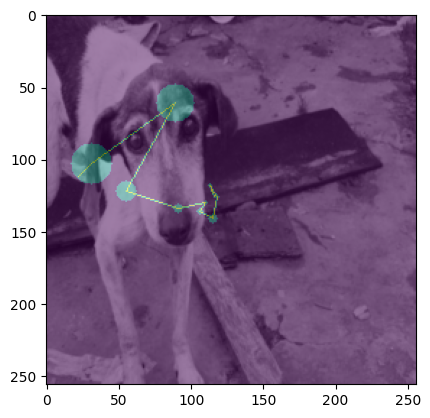

------------------


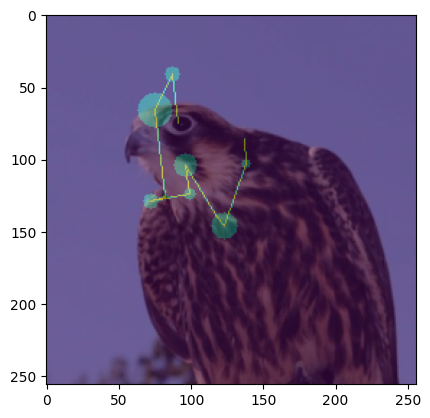

------------------


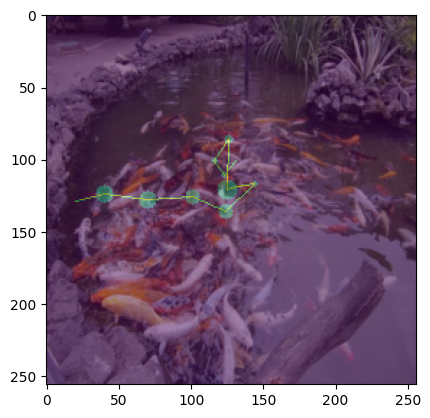

------------------


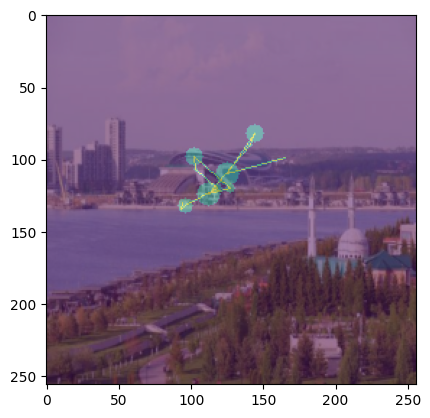

------------------


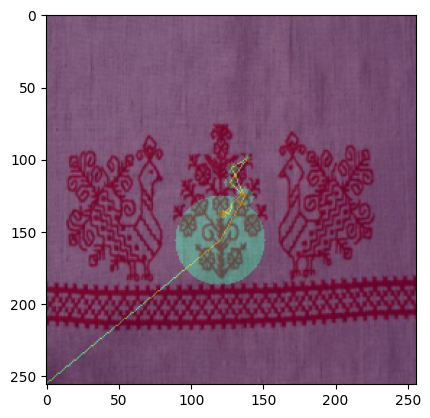

------------------


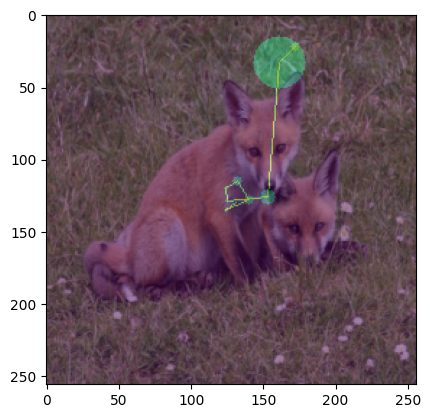

------------------


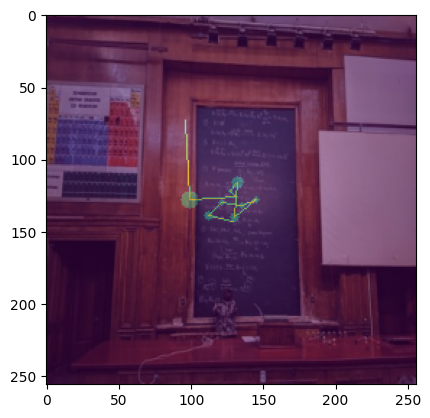

------------------


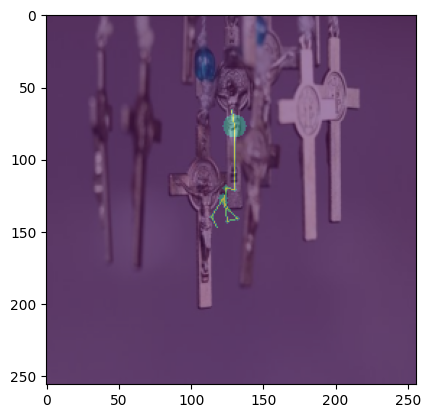

------------------


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [22]:
im_size = 256

transform = A.Compose([
    A.Resize(im_size, im_size),

    A.HorizontalFlip(p=0.5),
    A.Rotate(3),
    # A.Normalize(mean=0.5,std=0.5),
    # ToTensorV2(),
],keypoint_params=A.KeypointParams(format='xy')# bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, main_folder='prep_data/epochs/', img_transform=None):  # I use df to extract paths. We may filter df by images/participants/etc
        self.df = df
        self.arousal = np.array(df.arousal)
        self.valence = np.array(df.valence)
        
        self.paths = np.array(df.path)
        self.folder = np.array(df.participant)
        self.main_folder = main_folder
        
        self.img_names = np.array(df.image)
        self.img_transform = img_transform
        
    def __len__(self):
        return len(self.df)
    

    # @staticmethod
    # def _perc_coords_to_bboxes(img_shape, perc_coords):
    #     result = []
    #     for x, y in perc_coords:
    #         lux, luy = int(np.clip(x, 0, 1-0.05) * img_shape[1]), int(np.clip(y, 0, 1-0.05) * img_shape[0])
    #         w = img_shape[1] - lux
    #         h = img_shape[0] - luy

    #         result.append((lux, luy, w, h))

    #     return result
    
    # @staticmethod
    # def _bboxes_to_perc_coords(img_shape, pseudo_bboxes):
    #     return [[x / img_shape[1], y / img_shape[0]] for x, y, _, _ in pseudo_bboxes]


    @staticmethod
    def _perc_coords_to_keypoints(img_shape, perc_coords):
        result = []
        for x, y in perc_coords:
            lux, luy = int(np.clip(x, 0, 1) * img_shape[1]), int(np.clip(y, 0, 1) * img_shape[0])
            result.append((lux, luy))

        return result

    @staticmethod
    def _keypoints_to_perc_coords(img_shape, keypoints):
        return [[x / img_shape[1], y / img_shape[0]] for x, y in keypoints]
        
    def __getitem__(self, idx):

        data = pd.read_csv(self.main_folder+'/'+str(self.folder[idx])+'/'+self.paths[idx])
        y = torch.tensor([self.arousal[idx], self.valence[idx]])
        
        data.loc[[0, 300], ['FPOGV', 'LPMMV', 'RPMMV', 'GSRV', 'HRV']] = 1 # trick for interpolation to workaround cases when first/last values are not valid
        
        data.loc[data['FPOGV'] == 0, ['FPOGX', 'FPOGY']] = np.nan
        data.loc[data['LPMMV'] == 0, ['LPMM']] = np.nan
        data.loc[data['RPMMV'] == 0, ['RPMM']] = np.nan
        data.loc[data['GSRV'] == 0, ['GSR']] = np.nan
        data.loc[data['HRV'] == 0, ['HR']] = np.nan
        
        data[['FPOGX', 'FPOGY', 'FPOGID', 'LPMM', 'RPMM', 'GSR', 'HR']] = data[['FPOGX', 'FPOGY', 'FPOGID', 'LPMM', 'RPMM', 'GSR', 'HR']].interpolate(method='linear', axis=0)
        
        data['mean_PMM'] = (data.LPMMV + data.RPMMV)/2 
        
        data.GSR = data.GSR.rolling(window=60, min_periods=0, center=True).mean()
        data.mean_PMM = data.mean_PMM.rolling(window=10, min_periods=0, center=True).mean()
        
        
        ###
        t = transforms.Compose([
            transforms.Resize((256, 256)),
        ])
        x_image = Image.open('raw_data/Images/'+self.img_names[idx]).convert("RGB")
        x_image = t(x_image)
        # x_image = cv2.imread('raw_data/Images/'+self.img_names[idx])
        # x_image = cv2.cvtColor(x_image, cv2.COLOR_GRAY2RGB if len(x_image.shape) < 3 else cv2.COLOR_BGR2RGB)

        # transformed = self.img_transform(image=x_image,
        #                                  keypoints=self._perc_coords_to_keypoints(x_image.shape, data[['FPOGX', 'FPOGY']].values.tolist()),
        #                                 #  category_ids=np.arange(len(data))
        #                                  )

        # x_image = transformed['image']
        
        # data[['FPOGX', 'FPOGY']] = self._keypoints_to_perc_coords((im_size, im_size), transformed['keypoints']) #self._bboxes_to_perc_coords((im_size, im_size), transformed['bboxes'])

        ###
        # to create img from scan path - very straightforward but working function written in a noob way
        i1, i2 = 0, 300

        img_ = np.zeros((im_size, im_size), dtype=np.uint8)
        x0, y0 = data.FPOGX[i1], data.FPOGY[i1]
        for i in range(i1, i2):
            if ((data.FPOGID[i] != data.FPOGID[i+1])):

                x1, y1 = int(x0*im_size), int(y0*im_size)  
                x2, y2 = int(data.FPOGX[i]*im_size), int(data.FPOGY[i]*im_size)   

                cv2.line(img_, (x1, y1), (x2, y2), 255, 1)

                overlay = img_.copy()
                radius = int(((y2-y1)**2 + (x2-x1)**2)**0.5 / 5)
                cv2.circle(overlay, (x2, y2), radius, 255, -1)
                alpha = 0.5
                img_ = cv2.addWeighted(overlay, alpha, img_, 1 - alpha, 0)

                x0, y0 = data.FPOGX[i], data.FPOGY[i]

        x1, y1 = int(x0*im_size), int(y0*im_size)   
        x2, y2 = int(data.FPOGX[i2-1]*im_size), int(data.FPOGY[i2-1]*im_size)  

        cv2.line(img_, (x1, y1), (x2, y2), 255, 1)
        
        x_scanpath = (torch.tensor(img_, dtype=torch.float32)/255 - 0.5)/0.5
        
        
        # Normalize data by some reasonable values
        
        x_time = data[['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']]
        x_time = np.array(x_time)
        x_time = x_time.T
        x_time[[0, 1]] = (x_time[[0, 1]] - 0.5) / 0.5 # 'FPOGX', 'FPOGY' - X Y are from 0 to 1 with some outliers - lets normalise it by mean 0.5 and sd 0.5
        x_time[2] = (x_time[2] - 3)/0.4 # 'mean_PMM' - just rounded mean and sd of pupil size
        if round(x_time[3].std(), 3) == 0: # 'GSR' - GSR is veeeery noisy even in one recording - I use mean and sd for normalization of each epoch
            x_time[3] = 0
        else:
            x_time[3] = (x_time[3] - x_time[3].mean()) / x_time[3].std()
        
        x_time[4] = (x_time[4] - 80) / 15 # 'HR' - mean and sd of heart rate (BMP)
        x_time = torch.tensor(x_time, dtype=torch.float32)

        

        # ==============================================

        plt.imshow(x_image)

        flipped = cv2.flip(img_, 0)
        plt.imshow(flipped, alpha=0.5)
        plt.show()
        print('------------------')

        # ==============================================


        return x_image, x_scanpath, x_time, y

train_dataset = Dataset(df, img_transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

x_image, x_scanpath, x_time, y = next(iter(train_dataloader))





x_image.shape, x_scanpath.shape, x_time.shape, y.shape
